<a href="https://colab.research.google.com/github/joaomanojr/tecprog/blob/main/frozen_lake_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

class LinearDeepQNetwork(nn.Module):
  def __init__(self, lr, n_actions, input):
    super(LinearDeepQNetwork, self).__init__()

    self.fc1 = nn.Linear(input, 128)
    self.fc2 = nn.Linear(128, n_actions)

    # Author: self.parameters() from inherited class Module
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    # Author: pytorch have different tensors for cuda/cpu devices
    self.to(self.device)

  def forward(self, state):
    layer1 = F.relu(self.fc1(state))
    # Author: MSELoss will take care of activation for us...
    actions = self.fc2(layer1)

    return actions


class Agent():
  def __init__(self, lr, n_actions, gamma=0.95,
               epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
    """ Agent init takes:
    --
    lr - alpha learning rate factor
    input_dims - from our environment dimensions
    n_actions - actions space dimension
    gamma - discount factor on MDP rewards
    epsilon - Epsilon Greedy initial value (exploration threshold)
    eps_dec - Epsilon Greedy decrease factor
    eps_min - Epsilon Greedy minimum, final value (must be > 0)
      
    """
    self.lr = lr
    # Joao: hardcoded as 1
    self.input_dims = 16
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min
    self.action_space = [i for i in range(self.n_actions)]
    self.np_arrays = []
    for i in range(self.input_dims):
      self.np_arrays.append(self.one_hot_state(i))

    self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

  def one_hot_state(self, state):
    state_m = np.zeros((1, self.input_dims))
    state_m[0][state] = 1
    return state_m

  def choose_action(self, observation):
    ''' Choose Epsilon Greedy action for a given state '''
    rand_ = np.random.random()
    # print(f'rand_ is {rand_}')

    if rand_ > self.epsilon:
      state = T.tensor(self.np_arrays[observation], dtype=T.float).to(self.Q.device)
      ## print(f'state is {state}')
      ## print(f'state is {state.unsqueeze(dim=0)}')
      # https://stackoverflow.com/questions/64192810/runtime-error-both-arguments-to-matmul-need-to-be-at-least-1d-but-they-are-0d
      actions = self.Q.forward(state.unsqueeze(dim=0))
      action = T.argmax(actions).item()
    else:
      action = np.random.choice(self.action_space)
      ## print(f'random action {action}')

    return action
    
  def decrement_epsilon(self):
    ''' Epsilon decrease function (linear) '''
    # Look: my beloved C ternary in python terms!
    self.epsilon = self.epsilon - self.eps_dec \
                      if self.epsilon > self.eps_min else self.eps_min
   
  def learn(self, state, action, reward, state_, done):
    """ Off Policy (always Greedy) Learn function 
    --
    Here defined as plain Bellman equation, state_ is state'
    """
    self.Q.optimizer.zero_grad()
    state_T = T.tensor(self.np_arrays[state_], dtype=T.float).to(self.Q.device)

    #print(f'reward is {reward}')
    if not done:
      actions_T = self.Q.forward(state_T.unsqueeze(dim=0))
      reward = reward + self.gamma * T.argmax(actions_T).item()

    stateT = T.tensor(self.np_arrays[state], dtype=T.float).to(self.Q.device)
    targetT = self.Q.forward(stateT.unsqueeze(dim=0))

    #print(f'reward_ is {reward}')
    #print(f'targetT is {targetT}')

    #actions = T.tensor(action).to(self.Q.device)
    #rewards = T.tensor(reward).to(self.Q.device)

    ## q_pred = self.Q.forward(stateT.unsqueeze(dim=0))[actions]
    ## q_next = self.Q.forward(states_).max()
## 
    ## q_target = reward + self.gamma*q_next
## 
    ## # evaluate loss (cost) as the difference at better known and actual
    ## # action.

    q_pred = self.Q.forward(stateT.unsqueeze(dim=0))
    q_target = q_pred
    q_target[0][0][action] = reward
    loss = self.Q.loss(q_pred, q_target).to(self.Q.device)
    ## # Author: backpropagate cost and add a step on our optimizer.
    ## # These two calls are critical for learn loop.
    loss.backward()
## 
    self.Q.optimizer.step()
    self.decrement_epsilon()


episode 0 win pct 0.00 epsilon 1.00
episode 100 win pct 0.00 epsilon 0.99
episode 200 win pct 0.04 epsilon 0.98
episode 300 win pct 0.03 epsilon 0.98
episode 400 win pct 0.02 epsilon 0.97
episode 500 win pct 0.00 epsilon 0.96
episode 600 win pct 0.00 epsilon 0.95
episode 700 win pct 0.00 epsilon 0.95
episode 800 win pct 0.02 epsilon 0.94
episode 900 win pct 0.02 epsilon 0.93
episode 1000 win pct 0.00 epsilon 0.92
episode 1100 win pct 0.02 epsilon 0.91
episode 1200 win pct 0.00 epsilon 0.90
episode 1300 win pct 0.01 epsilon 0.90
episode 1400 win pct 0.02 epsilon 0.89
episode 1500 win pct 0.01 epsilon 0.88
episode 1600 win pct 0.00 epsilon 0.87
episode 1700 win pct 0.02 epsilon 0.86
episode 1800 win pct 0.02 epsilon 0.86
episode 1900 win pct 0.02 epsilon 0.85
episode 2000 win pct 0.02 epsilon 0.84
episode 2100 win pct 0.02 epsilon 0.83
episode 2200 win pct 0.03 epsilon 0.83
episode 2300 win pct 0.01 epsilon 0.82
episode 2400 win pct 0.03 epsilon 0.81
episode 2500 win pct 0.02 epsilon 0.8

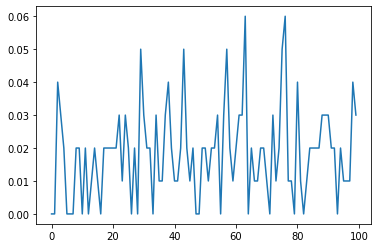

In [22]:
import gym
import matplotlib.pyplot as plt
import numpy as np

env = gym.make('FrozenLake-v0')

n_games = 10000
scores = []
win_pct_list = []

agent = Agent(lr=0.0001, n_actions=4)

for i in range(n_games):
  score = 0
  done = False
  # This looks like a context pointer to created environment, here we are
  # just initializing it - it returns our current state also;
  obs = env.reset()

  # Interact with environment until done (end or fall in a hole)
  while not done:
    action = agent.choose_action(obs)
    obs_, reward, done, info = env.step(action)
    #env.render()
    score += reward
    agent.learn(obs, action, reward, obs_, done)
    obs = obs_
  scores.append(score)
  
  if i % 100 == 0:
    win_pct = np.mean(scores[-100:])
    win_pct_list.append(win_pct)
    print('episode', i, 'win pct %.2f' % win_pct,
          'epsilon %.2f' % agent.epsilon)
  
plt.plot(win_pct_list)
plt.show()